In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('all_faults.csv')

In [3]:
df['fault'].unique()

array(['14_BF', '14_IR', '14_OR1', '21_BF', '21_IR', '21_OR1', '21_OR2',
       '21_OR3', '7_BF', '7_IR', '7_OR1', '7_OR2', '7_OR3', 'N'],
      dtype=object)

In [4]:
df

,DE_data,fault
0,0.039846,14_BF
1,0.089705,14_BF
2,0.136643,14_BF
3,0.177532,14_BF
4,0.205903,14_BF
...,...,...
2782624,-0.059664,N
2782625,-0.063836,N
2782626,-0.034630,N
2782627,0.016689,N


In [5]:
 df_temp_2 = df[df['fault']=='14_BF'] #data for only 14_BF 

In [6]:
df_temp_2

,DE_data,fault
0,0.039846,14_BF
1,0.089705,14_BF
2,0.136643,14_BF
3,0.177532,14_BF
4,0.205903,14_BF
...,...,...
249141,0.045895,14_BF
249142,0.028163,14_BF
249143,0.008970,14_BF
249144,-0.010014,14_BF


In [7]:
len(df_temp_2)

249146

In [9]:
#segmentation using the window length
win_len=1000
stride=200

for i in np.arange(0,len(df_temp_2)-(win_len),stride): #a for loop that starts at 0 and goes until this len 
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))


In [10]:
#Append the temp value in the X array and corresponding fault value in the Y array 
X=[]
Y=[]

X.append(temp)
Y.append(df_temp_2.iloc[i+win_len,-1])

In [11]:
np.shape(X) #the shape of the array  has one row and 1000 culumns

(1, 1, 1000)

# Segmenting the vibration signals into small portions using a window

In [14]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=1000
stride=200

X=[]
Y=[]


for k in df['fault'].unique(): #loop through all the fault and append their value in x and y array
    
    df_temp_2 = df[df['fault']==k]
    
    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp) #append the value of temp for each fault in the X array
        Y.append(df_temp_2.iloc[i+win_len,-1]) #Append the corresponding value of the fault in Y array
    
X=np.array(X) #convert to numpy array 
X=X.reshape((X.shape[0],win_len)) #reshape, taking number of instances and the window length



Y=np.array(Y) #the label value
encoder= LabelEncoder()
encoder.fit(Y) #encoding the label value eg 14_BF = 1 etc
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y) #convert the label value to one hot encoder

In [13]:
X.shape #13848 samples and each having a dimension of 100

(13848, 1000)

# Splitting the dataset into training and testing sets

In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

# Visulaizing the data using t-sne before using Auto-Encoders

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13848 samples in 1.277s...
[t-SNE] Computed neighbors for 13848 samples in 339.776s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13848
[t-SNE] Computed conditional probabilities for sample 2000 / 13848
[t-SNE] Computed conditional probabilities for sample 3000 / 13848
[t-SNE] Computed conditional probabilities for sample 4000 / 13848
[t-SNE] Computed conditional probabilities for sample 5000 / 13848
[t-SNE] Computed conditional probabilities for sample 6000 / 13848
[t-SNE] Computed conditional probabilities for sample 7000 / 13848
[t-SNE] Computed conditional probabilities for sample 8000 / 13848
[t-SNE] Computed conditional probabilities for sample 9000 / 13848
[t-SNE] Computed conditional probabilities for sample 10000 / 13848
[t-SNE] Computed conditional probabilities for sample 11000 / 13848
[t-SNE] Computed conditional probabilities for sample 12000 / 13848
[t-SNE] Computed conditional probabilities for 

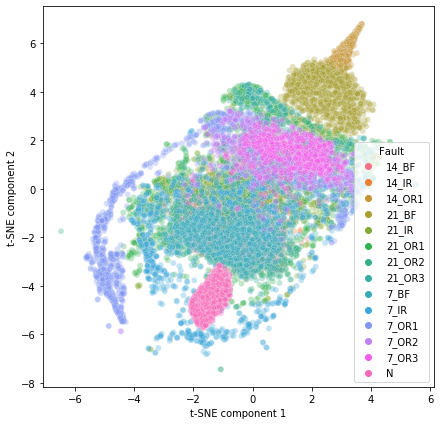

In [21]:
X_pre_aen = X #create a new array and pass value of existing X array

from sklearn.manifold import TSNE #import TSNE for visualization

X_t_sne = TSNE(n_components=2,verbose=1, perplexity=40, n_iter=300).fit_transform(X_pre_aen)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['t-SNE component 1', 't-SNE component 2'])

tSNEdf['Fault']=Y


#Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(x=tSNEdf['t-SNE component 1'],y=tSNEdf['t-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

# Create the Neural Network

In [22]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten

no_classes=len(encoder.classes_) #will be equal to the number of faults
# build a model
model = Sequential() #will start the graph
model.add(Dense(1024, input_shape=(X.shape[1],), activation='relu')) # input shape is (features,)
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))
model.summary()

# compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', # this is different instead of binary_crossentropy (for regular classification)
              metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              1025024   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 14)                1806      
Total params: 1,715,854
Trainable params: 1,715,854
Non-trainable params: 0
____________________________________________________________

In [23]:
#fit the data
history = model.fit(X_train,
                    y_train,
                    epochs=50, # you can set this to a big number!
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test,y_test),
                    verbose=1)

Train on 9693 samples, validate on 4155 samples
Epoch 1/50
9693/9693 [==============================] - 3s 319us/sample - loss: 1.7871 - acc: 0.3706 - val_loss: 1.2760 - val_acc: 0.5369
Epoch 2/50
9693/9693 [==============================] - 2s 243us/sample - loss: 0.9197 - acc: 0.7038 - val_loss: 0.6553 - val_acc: 0.8207
Epoch 3/50
9693/9693 [==============================] - 2s 242us/sample - loss: 0.5144 - acc: 0.8544 - val_loss: 0.5791 - val_acc: 0.8099
Epoch 4/50
9693/9693 [==============================] - 2s 245us/sample - loss: 0.3042 - acc: 0.9062 - val_loss: 0.2790 - val_acc: 0.9061
Epoch 5/50
9693/9693 [==============================] - 2s 247us/sample - loss: 0.1487 - acc: 0.9555 - val_loss: 0.2753 - val_acc: 0.9131
Epoch 6/50
9693/9693 [==============================] - 2s 242us/sample - loss: 0.1075 - acc: 0.9687 - val_loss: 0.2141 - val_acc: 0.9384
Epoch 7/50
9693/9693 [==============================] - 2s 243us/sample - loss: 0.0702 - acc: 0.9835 - val_loss: 0.2122 - va

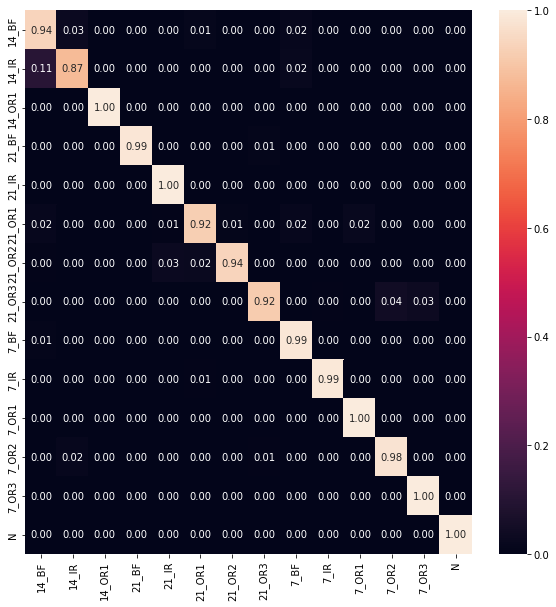

In [31]:
#confusion Matrix

def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, Y_pred)
# Normalize
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,10))
f = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

In [34]:
dummy_ann = Model(inputs=model.input,outputs=model.layers[-2].output) #take the second last layer of the model
y_viz = dummy_ann.predict(X_train) #pass the data

In [35]:
y_viz.shape

(9693, 128)

In [39]:
def T_SNE_plot(X_train,y_train,model,encoder):
    dummy_ann = Model(inputs=model.input,outputs=model.layers[-2].output)
    y_viz = dummy_ann.predict(X_train)
    
    from sklearn.manifold import TSNE

    X_t_sne = TSNE(n_components=2,verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

    tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

    tSNEdf['Fault']=inv_Transform_result(y_train)


    # Plot the PC-1 and PC-2
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
        data=tSNEdf,
        legend="full",
        alpha=0.3)
    plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9693 samples in 0.207s...
[t-SNE] Computed neighbors for 9693 samples in 4.553s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9693
[t-SNE] Computed conditional probabilities for sample 2000 / 9693
[t-SNE] Computed conditional probabilities for sample 3000 / 9693
[t-SNE] Computed conditional probabilities for sample 4000 / 9693
[t-SNE] Computed conditional probabilities for sample 5000 / 9693
[t-SNE] Computed conditional probabilities for sample 6000 / 9693
[t-SNE] Computed conditional probabilities for sample 7000 / 9693
[t-SNE] Computed conditional probabilities for sample 8000 / 9693
[t-SNE] Computed conditional probabilities for sample 9000 / 9693
[t-SNE] Computed conditional probabilities for sample 9693 / 9693
[t-SNE] Mean sigma: 2.562549
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.834831
[t-SNE] KL divergence after 300 iterations: 2.166627


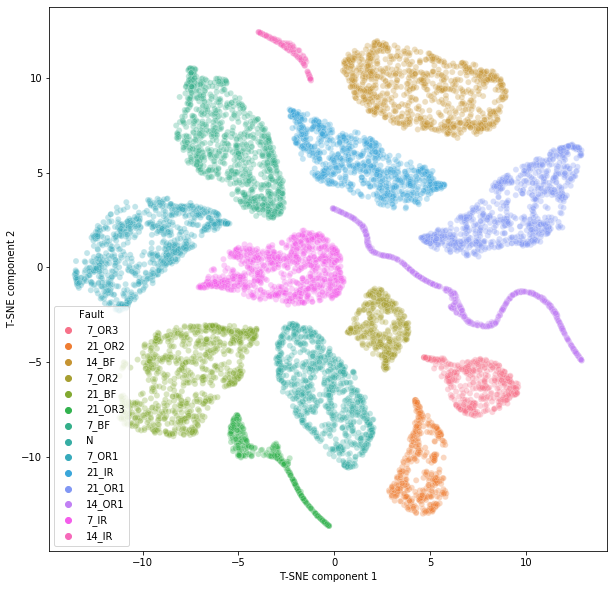

In [40]:
T_SNE_plot(X_train,y_train,model,encoder)